In [1]:
import os
import sys

lib_path = os.path.abspath("").replace("notebooks", "src")
sys.path.append(lib_path)

import torch
import matplotlib.pyplot as plt

from transformers import BertTokenizer
from data.dataloader import build_train_test_dataset
from tqdm.auto import tqdm
import numpy as np
from models import networks
from transformers import BertTokenizer, RobertaTokenizer
from sklearn.decomposition import PCA
from configs.base import Config
root_path = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))

/home/namphuongtran9196/.miniconda3/envs/SER/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def eval_pca(cfg, checkpoint_path, all_state_dict=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    try:
        network = getattr(networks, cfg.model_type)(cfg)
        network.to(device)
    except AttributeError:
        raise NotImplementedError("Model {} is not implemented".format(cfg.model_type))

    # Build dataset
    # Build dataset
    encoder_model = None
    if cfg.encode_data:
        network.embed_input = True
        encoder_model = network
    train_ds, test_ds = build_train_test_dataset(cfg, encoder_model)
    weight = torch.load(checkpoint_path, map_location=torch.device(device))
    if all_state_dict:
        weight = weight["state_dict_network"]
    else:
        weight = weight.state_dict()
    network.load_state_dict(weight)
    network.eval()
    network.to(device)

    # Get train features
    X = []
    y = []
    # count = 0
    for every_train_list in tqdm(train_ds):
        # if count==100:
        #     break
        # count+=1
        input_ids, audio, label = every_train_list
        input_ids = input_ids.to(device)
        audio = audio.to(device)
        label = label.to(device)
        with torch.no_grad():
            feature = network(input_ids,audio)[1].detach().cpu().numpy()[0]
            feature_norm = feature / np.linalg.norm(feature)
            X.append(feature_norm)
            y.append(label.detach().cpu().numpy()[0])
    
    # SVM
    pca = PCA(n_components=2)
    X_transformed = pca.fit_transform(X)
    fig = plt.figure(figsize=(5, 5))
    # # 3D plot
    # ax = fig.add_subplot(111, projection='3d')
    # scatter = ax.scatter(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2], c=y)
    # 2D plot
    ax = fig.add_subplot(111)
    scatter = ax.scatter(X_transformed[:,0], X_transformed[:,1], c=y)
    # remove ticks
    ax.xaxis.set(ticks=())
    ax.yaxis.set(ticks=())
    # set step 0.5 for ticks
    # ax.xaxis.set(ticks=np.arange(-1.25, 1.26, 0.5))
    # ax.yaxis.set(ticks=np.arange(-1.25, 1.26, 0.5))
    # # 3D plot
    # ax.zaxis.set(ticks=np.arange(-1.25, 1.26, 0.5))

    # add legend
    # legend1 = ax.legend(*scatter.legend_elements(),
    #                     loc="upper left", title="")
    # legend1.get_texts()[0].set_text('Angry')
    # legend1.get_texts()[1].set_text('Happy')
    # legend1.get_texts()[2].set_text('Sad')
    # legend1.get_texts()[3].set_text('Neutral')
    # ax.add_artist(legend1)

    # remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.tight_layout()
    plt.savefig(f"{cfg.name}_pca.png", dpi=300, bbox_inches='tight')
    plt.show()

100%|██████████| 4479/4479 [01:45<00:00, 42.42it/s]


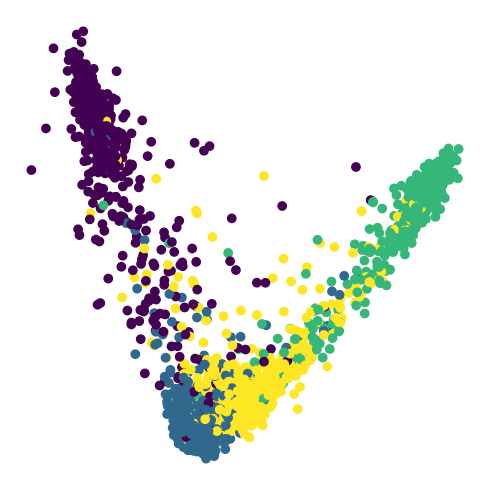

In [3]:
checkpoint_path = "/home/namphuongtran9196/Code/EmotionClassification/code/3m-ser-private/scripts/checkpoints/checkpoints_latest/IEMOCAP/3M-SER_losses/CrossEntropyLoss_CenterLoss_bert_vggish_cls/20240131-083756"
cfg_path = os.path.join(checkpoint_path, "cfg.log")
ckpt_path = os.path.join(
    checkpoint_path, "weights/best_acc/checkpoint_0_0.pt"
)
cfg = Config()
cfg.load(cfg_path)
        
eval_pca(cfg, ckpt_path)

100%|██████████| 4479/4479 [01:40<00:00, 44.57it/s]


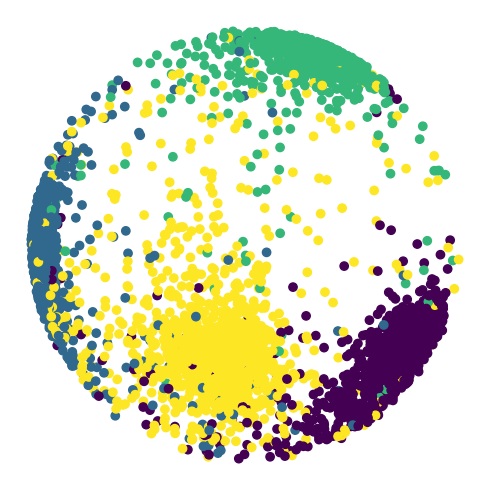

In [4]:
checkpoint_path = "/home/namphuongtran9196/Code/EmotionClassification/code/3m-ser-private/scripts/checkpoints/checkpoints_latest/IEMOCAP/3M-SER_losses/CrossEntropyLoss_CombinedMarginLoss_arcface_bert_vggish_cls/20240131-083815"
cfg_path = os.path.join(checkpoint_path, "cfg.log")
ckpt_path = os.path.join(
    checkpoint_path, "weights/best_acc/checkpoint_0_0.pt"
)
cfg = Config()
cfg.load(cfg_path)
        
eval_pca(cfg, ckpt_path)

100%|██████████| 4479/4479 [01:38<00:00, 45.35it/s]


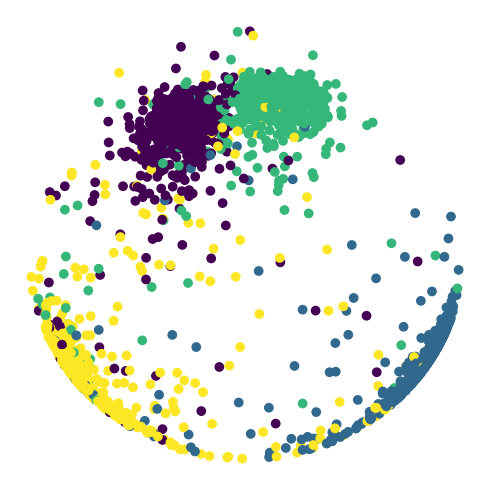

In [5]:
checkpoint_path = "/home/namphuongtran9196/Code/EmotionClassification/code/3m-ser-private/scripts/checkpoints/checkpoints_latest/IEMOCAP/3M-SER_losses/CrossEntropyLoss_CombinedMarginLoss_cosface_bert_vggish_cls/20240131-084218"
cfg_path = os.path.join(checkpoint_path, "cfg.log")
ckpt_path = os.path.join(
    checkpoint_path, "weights/best_acc/checkpoint_0_0.pt"
)
cfg = Config()
cfg.load(cfg_path)
        
eval_pca(cfg, ckpt_path)

100%|██████████| 4479/4479 [01:34<00:00, 47.43it/s]


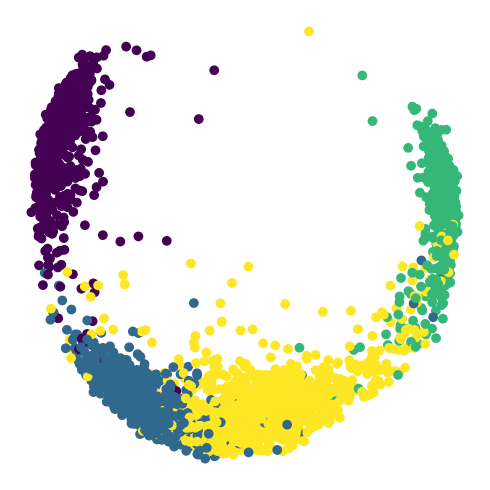

In [6]:
checkpoint_path = "/home/namphuongtran9196/Code/EmotionClassification/code/3m-ser-private/scripts/checkpoints/checkpoints_latest/IEMOCAP/3M-SER_losses/CrossEntropyLoss_ContrastiveCenterLoss_bert_vggish_cls/20240131-083741"
cfg_path = os.path.join(checkpoint_path, "cfg.log")
ckpt_path = os.path.join(
    checkpoint_path, "weights/best_acc/checkpoint_0_0.pt"
)
cfg = Config()
cfg.load(cfg_path)
        
eval_pca(cfg, ckpt_path)

100%|██████████| 4479/4479 [01:46<00:00, 41.92it/s]


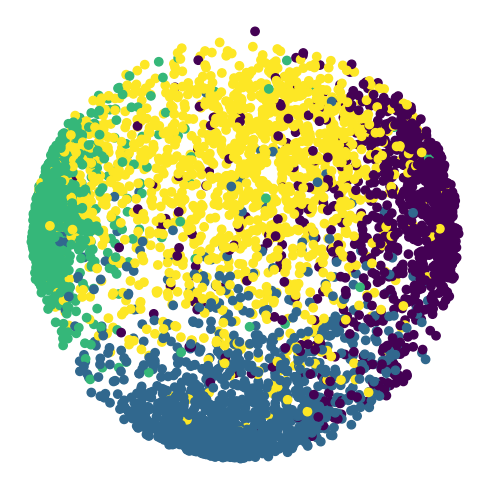

In [3]:
checkpoint_path = "/home/namphuongtran9196/Code/EmotionClassification/code/3m-ser-private/scripts/checkpoints/checkpoints_latest/IEMOCAP/3M-SER/CrossEntropyLoss_bert_vggish_cls/20240131-192619"
cfg_path = os.path.join(checkpoint_path, "cfg.log")
ckpt_path = os.path.join(
    checkpoint_path, "weights/best_acc/checkpoint_0_0.pt"
)
cfg = Config()
cfg.load(cfg_path)
        
eval_pca(cfg, ckpt_path)

100%|██████████| 4479/4479 [01:52<00:00, 39.72it/s]


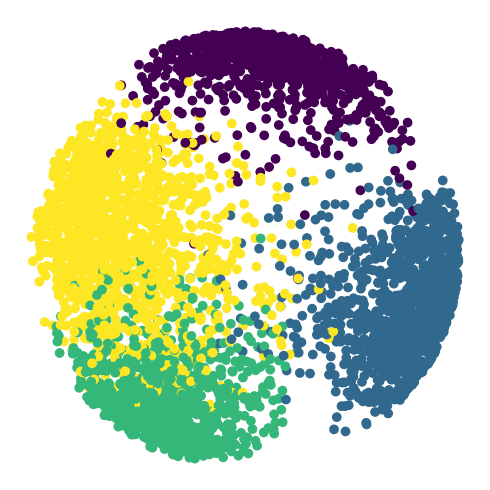

In [4]:
checkpoint_path = "/home/namphuongtran9196/Code/EmotionClassification/code/3m-ser-private/scripts/checkpoints/checkpoints_latest/IEMOCAP/3M-SER_losses/FocalLoss_bert_vggish_cls/20240131-105126"
cfg_path = os.path.join(checkpoint_path, "cfg.log")
ckpt_path = os.path.join(
    checkpoint_path, "weights/best_acc/checkpoint_0_0.pt"
)
cfg = Config()
cfg.load(cfg_path)
        
eval_pca(cfg, ckpt_path)